In [ ]:
! pip install nnfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

In [ ]:
# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [ ]:
# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

In [ ]:
# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


In [ ]:
# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates


    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

In [ ]:
class Optimizer_Adagrad:
    def __init__(self, learning_rate=0.01, decay=0.0, epsilon=1e-7):
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.iterations = 0
        self.cache = {}

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.current_learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        weight_gradients = layer.dweights
        bias_gradients = layer.dbiases

        # Update cache with squares of gradients
        self.cache.setdefault(layer, {})
        self.cache[layer]['weight'] = self.cache[layer].get('weight', 0.0) + np.square(weight_gradients)
        self.cache[layer]['bias'] = self.cache[layer].get('bias', 0.0) + np.square(bias_gradients)

        # Compute update
        weight_updates = - self.current_learning_rate * (weight_gradients / (np.sqrt(self.cache[layer]['weight']) + self.epsilon))
        bias_updates = - self.current_learning_rate * (bias_gradients / (np.sqrt(self.cache[layer]['bias']) + self.epsilon))

        # Update weights and biases using adagrad updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1


In [ ]:
# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings,
    # learning rate of 0.001 is default for this optimizer
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain momentum and cache arrays, create them
        # filled with zeros
        if not hasattr(layer, 'weight_momentums'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            # If there is no momentum and cache array for weights
            # The arrays don't exist for biases yet either.
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = \
            self.beta_1 * layer.weight_momentums + \
            (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = \
            self.beta_1 * layer.bias_momentums + \
            (1 - self.beta_1) * layer.dbiases

        # Update cache with squared current gradients
        layer.weight_cache = \
            self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = \
            self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases ** 2

        # Compute bias-corrected momentum and cache
        weight_momentums_corrected = \
            layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = \
            layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        weight_cache_corrected = \
            layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = \
            layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Compute adaptive learning rate
        weight_updates = \
            -self.current_learning_rate * \
            weight_momentums_corrected / \
            (np.sqrt(weight_cache_corrected) + self.epsilon)
        bias_updates = \
            -self.current_learning_rate * \
            bias_momentums_corrected / \
            (np.sqrt(bias_cache_corrected) + self.epsilon)

        # Update weights and biases using adaptive learning rate
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


In [ ]:
# RMSprop optimizer
class Optimizer_RMSprop:

    # Initialize optimizer - set settings,
    # learning rate of 0.001 is default for this optimizer
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays, create them
        # filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            # If there is no cache array for weights
            # The array doesn't exist for biases yet either.
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = \
            self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights ** 2
        layer.bias_cache = \
            self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases ** 2

        # Compute adaptive learning rate
        weight_updates = \
            -self.current_learning_rate * \
            layer.dweights / \
            (np.sqrt(layer.weight_cache) + self.epsilon)
        bias_updates = \
            -self.current_learning_rate * \
            layer.dbiases / \
            (np.sqrt(layer.bias_cache) + self.epsilon)

        # Update weights and biases using adaptive learning rate
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


In [ ]:
# Common loss class
class Loss:

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss

In [ ]:
# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [ ]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

epoch: 0, acc: 0.360, loss: 1.099, lr: 0.05
epoch: 100, acc: 0.417, loss: 1.099, lr: 0.05
epoch: 200, acc: 0.423, loss: 1.098, lr: 0.05
epoch: 300, acc: 0.427, loss: 1.098, lr: 0.05
epoch: 400, acc: 0.413, loss: 1.098, lr: 0.05
epoch: 500, acc: 0.413, loss: 1.098, lr: 0.05
epoch: 600, acc: 0.423, loss: 1.098, lr: 0.05
epoch: 700, acc: 0.427, loss: 1.098, lr: 0.05
epoch: 800, acc: 0.427, loss: 1.098, lr: 0.05
epoch: 900, acc: 0.417, loss: 1.097, lr: 0.05
epoch: 1000, acc: 0.417, loss: 1.097, lr: 0.05
epoch: 1100, acc: 0.407, loss: 1.097, lr: 0.05
epoch: 1200, acc: 0.407, loss: 1.096, lr: 0.05
epoch: 1300, acc: 0.407, loss: 1.095, lr: 0.05
epoch: 1400, acc: 0.400, loss: 1.094, lr: 0.05
epoch: 1500, acc: 0.400, loss: 1.093, lr: 0.05
epoch: 1600, acc: 0.400, loss: 1.092, lr: 0.05
epoch: 1700, acc: 0.403, loss: 1.091, lr: 0.05
epoch: 1800, acc: 0.403, loss: 1.090, lr: 0.05
epoch: 1900, acc: 0.400, loss: 1.088, lr: 0.05
epoch: 2000, acc: 0.397, loss: 1.087, lr: 0.05
epoch: 2100, acc: 0.397, 

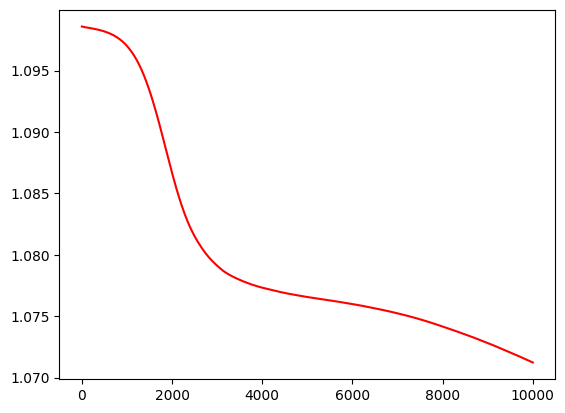

In [ ]:
# Driver Code for SGD(Red Curve)
# Create dataset
from matplotlib import pyplot as plt
loss_list2=[]
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_SGD(learning_rate=0.05)
#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    loss_list2.append(loss)
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='red')
#plt.plot(x1,loss_list1)

epoch: 0, acc: 0.343, loss: 1.099, lr: 0.05
epoch: 100, acc: 0.423, loss: 1.099, lr: 0.05
epoch: 200, acc: 0.407, loss: 1.098, lr: 0.05
epoch: 300, acc: 0.400, loss: 1.098, lr: 0.05
epoch: 400, acc: 0.397, loss: 1.098, lr: 0.05
epoch: 500, acc: 0.390, loss: 1.098, lr: 0.05
epoch: 600, acc: 0.383, loss: 1.098, lr: 0.05
epoch: 700, acc: 0.397, loss: 1.098, lr: 0.05
epoch: 800, acc: 0.410, loss: 1.098, lr: 0.05
epoch: 900, acc: 0.403, loss: 1.097, lr: 0.05
epoch: 1000, acc: 0.403, loss: 1.097, lr: 0.05
epoch: 1100, acc: 0.403, loss: 1.096, lr: 0.05
epoch: 1200, acc: 0.400, loss: 1.096, lr: 0.05
epoch: 1300, acc: 0.400, loss: 1.095, lr: 0.05
epoch: 1400, acc: 0.390, loss: 1.094, lr: 0.05
epoch: 1500, acc: 0.390, loss: 1.092, lr: 0.05
epoch: 1600, acc: 0.393, loss: 1.091, lr: 0.05
epoch: 1700, acc: 0.390, loss: 1.089, lr: 0.05
epoch: 1800, acc: 0.390, loss: 1.087, lr: 0.05
epoch: 1900, acc: 0.400, loss: 1.085, lr: 0.05
epoch: 2000, acc: 0.410, loss: 1.083, lr: 0.05
epoch: 2100, acc: 0.417, 

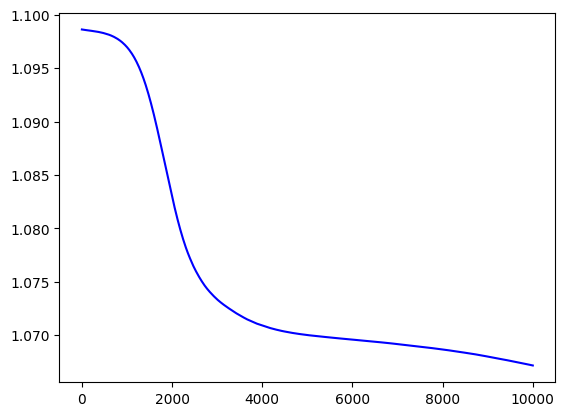

In [ ]:
# Driver Code for SGD(Red Curve)
# Create dataset
from matplotlib import pyplot as plt
loss_list1=[]
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_SGD(learning_rate=0.05)
#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    loss_list1.append(loss)
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
x1=range(epoch+1)
plt.plot(x1,loss_list1,color='blue')
#plt.plot(x1,loss_list1)

epoch: 0, acc: 0.320, loss: 1.099, lr: 0.1
epoch: 100, acc: 0.430, loss: 1.099, lr: 0.1
epoch: 200, acc: 0.423, loss: 1.098, lr: 0.1
epoch: 300, acc: 0.413, loss: 1.098, lr: 0.1
epoch: 400, acc: 0.413, loss: 1.098, lr: 0.1
epoch: 500, acc: 0.407, loss: 1.098, lr: 0.1
epoch: 600, acc: 0.400, loss: 1.097, lr: 0.1
epoch: 700, acc: 0.393, loss: 1.097, lr: 0.1
epoch: 800, acc: 0.390, loss: 1.096, lr: 0.1
epoch: 900, acc: 0.390, loss: 1.094, lr: 0.1
epoch: 1000, acc: 0.390, loss: 1.093, lr: 0.1
epoch: 1100, acc: 0.383, loss: 1.091, lr: 0.1
epoch: 1200, acc: 0.383, loss: 1.088, lr: 0.1
epoch: 1300, acc: 0.387, loss: 1.086, lr: 0.1
epoch: 1400, acc: 0.387, loss: 1.084, lr: 0.1
epoch: 1500, acc: 0.393, loss: 1.083, lr: 0.1
epoch: 1600, acc: 0.393, loss: 1.082, lr: 0.1
epoch: 1700, acc: 0.393, loss: 1.081, lr: 0.1
epoch: 1800, acc: 0.390, loss: 1.080, lr: 0.1
epoch: 1900, acc: 0.383, loss: 1.080, lr: 0.1
epoch: 2000, acc: 0.383, loss: 1.079, lr: 0.1
epoch: 2100, acc: 0.387, loss: 1.079, lr: 0.1


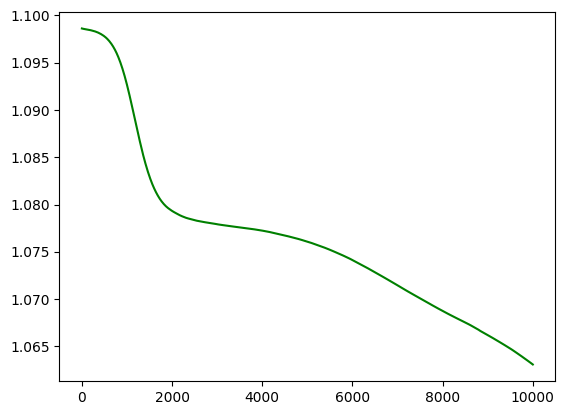

In [ ]:
# Driver Code for SGD(Red Curve)
# Create dataset
from matplotlib import pyplot as plt
loss_list3=[]
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_SGD(learning_rate=0.1)
#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    loss_list3.append(loss)
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
x1=range(epoch+1)
plt.plot(x1,loss_list3,color='green')
#plt.plot(x1,loss_list1)

epoch: 0, acc: 0.350, loss: 1.099, lr: 0.5
epoch: 100, acc: 0.457, loss: 1.090, lr: 0.5
epoch: 200, acc: 0.460, loss: 1.058, lr: 0.5
epoch: 300, acc: 0.460, loss: 1.055, lr: 0.5
epoch: 400, acc: 0.463, loss: 1.053, lr: 0.5
epoch: 500, acc: 0.463, loss: 1.052, lr: 0.5
epoch: 600, acc: 0.463, loss: 1.052, lr: 0.5
epoch: 700, acc: 0.460, loss: 1.052, lr: 0.5
epoch: 800, acc: 0.463, loss: 1.051, lr: 0.5
epoch: 900, acc: 0.450, loss: 1.051, lr: 0.5
epoch: 1000, acc: 0.447, loss: 1.051, lr: 0.5
epoch: 1100, acc: 0.450, loss: 1.050, lr: 0.5
epoch: 1200, acc: 0.453, loss: 1.049, lr: 0.5
epoch: 1300, acc: 0.453, loss: 1.048, lr: 0.5
epoch: 1400, acc: 0.453, loss: 1.046, lr: 0.5
epoch: 1500, acc: 0.457, loss: 1.044, lr: 0.5
epoch: 1600, acc: 0.457, loss: 1.040, lr: 0.5
epoch: 1700, acc: 0.463, loss: 1.036, lr: 0.5
epoch: 1800, acc: 0.457, loss: 1.030, lr: 0.5
epoch: 1900, acc: 0.467, loss: 1.025, lr: 0.5
epoch: 2000, acc: 0.477, loss: 1.019, lr: 0.5
epoch: 2100, acc: 0.497, loss: 1.013, lr: 0.5


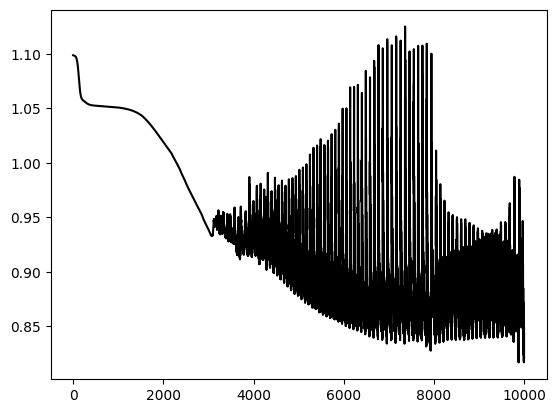

In [ ]:
# Driver Code for SGD(Red Curve)
# Create dataset
from matplotlib import pyplot as plt
loss_list4=[]
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_SGD(learning_rate=0.5)
#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    loss_list4.append(loss)
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
x1=range(epoch+1)
plt.plot(x1,loss_list4,color='black')
#plt.plot(x1,loss_list1)

[]

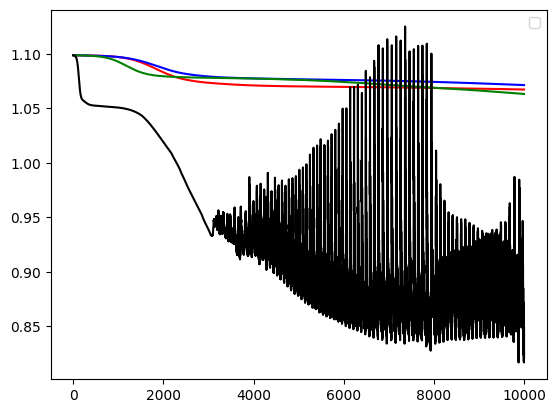

In [ ]:
x1=range(epoch+1)
plt.plot(x1,loss_list1,color='red')#0.05
plt.plot(x1,loss_list2,color='blue')#1
plt.plot(x1,loss_list3,color='green')#0.1
plt.plot(x1,loss_list4,color='black')#0.5
plt.legend()
plt.plot()

epoch: 0, acc: 0.327, loss: 1.099, lr: 0.05
epoch: 100, acc: 0.443, loss: 1.045, lr: 0.05
epoch: 200, acc: 0.463, loss: 1.015, lr: 0.05
epoch: 300, acc: 0.487, loss: 0.989, lr: 0.05
epoch: 400, acc: 0.517, loss: 0.969, lr: 0.05
epoch: 500, acc: 0.537, loss: 0.953, lr: 0.05
epoch: 600, acc: 0.537, loss: 0.939, lr: 0.05
epoch: 700, acc: 0.550, loss: 0.928, lr: 0.05
epoch: 800, acc: 0.550, loss: 0.919, lr: 0.05
epoch: 900, acc: 0.557, loss: 0.911, lr: 0.05
epoch: 1000, acc: 0.567, loss: 0.903, lr: 0.05
epoch: 1100, acc: 0.553, loss: 0.896, lr: 0.05
epoch: 1200, acc: 0.577, loss: 0.890, lr: 0.05
epoch: 1300, acc: 0.563, loss: 0.884, lr: 0.05
epoch: 1400, acc: 0.580, loss: 0.879, lr: 0.05
epoch: 1500, acc: 0.570, loss: 0.873, lr: 0.05
epoch: 1600, acc: 0.587, loss: 0.864, lr: 0.05
epoch: 1700, acc: 0.583, loss: 0.857, lr: 0.05
epoch: 1800, acc: 0.587, loss: 0.849, lr: 0.05
epoch: 1900, acc: 0.620, loss: 0.842, lr: 0.05
epoch: 2000, acc: 0.597, loss: 0.835, lr: 0.05
epoch: 2100, acc: 0.607, 

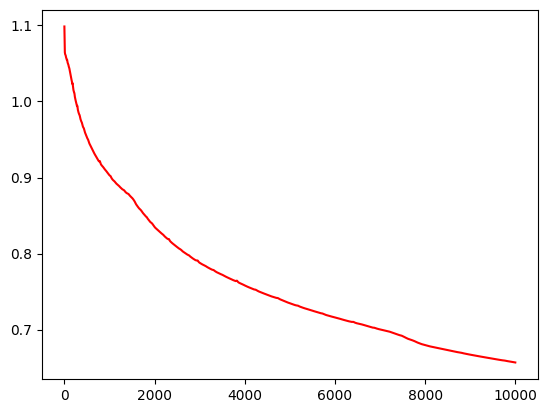

In [ ]:
# Driver Code for SGD(Red Curve)
# Create dataset
from matplotlib import pyplot as plt
loss_list_ad2=[]
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adagrad(learning_rate=0.05)
#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    loss_list_ad2.append(loss)
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
x1=range(epoch+1)
plt.plot(x1,loss_list_ad2,color='red')
#plt.plot(x1,loss_list1)

[]

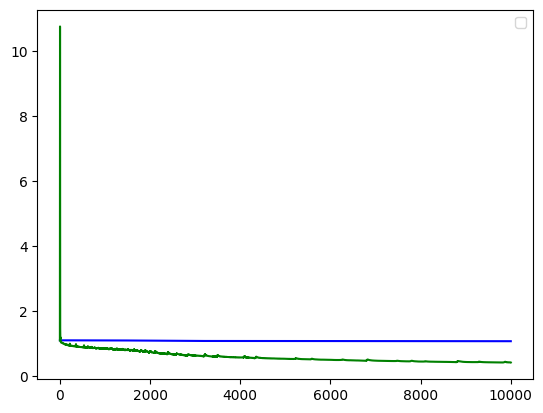

In [ ]:
x1=range(epoch+1)
plt.plot(x1,loss_list2,color='blue')#1
plt.plot(x1,loss_list_ad2,color='green')#1
plt.legend()
plt.plot()

epoch: 0, acc: 0.413, loss: 1.099, lr: 0.05
epoch: 100, acc: 0.523, loss: 0.901, lr: 0.05
epoch: 200, acc: 0.587, loss: 0.805, lr: 0.05
epoch: 300, acc: 0.657, loss: 0.694, lr: 0.05
epoch: 400, acc: 0.703, loss: 0.633, lr: 0.05
epoch: 500, acc: 0.723, loss: 0.584, lr: 0.05
epoch: 600, acc: 0.730, loss: 0.586, lr: 0.05
epoch: 700, acc: 0.730, loss: 0.568, lr: 0.05
epoch: 800, acc: 0.773, loss: 0.504, lr: 0.05
epoch: 900, acc: 0.763, loss: 0.493, lr: 0.05
epoch: 1000, acc: 0.753, loss: 0.484, lr: 0.05
epoch: 1100, acc: 0.763, loss: 0.471, lr: 0.05
epoch: 1200, acc: 0.767, loss: 0.473, lr: 0.05
epoch: 1300, acc: 0.797, loss: 0.440, lr: 0.05
epoch: 1400, acc: 0.760, loss: 0.496, lr: 0.05
epoch: 1500, acc: 0.773, loss: 0.460, lr: 0.05
epoch: 1600, acc: 0.797, loss: 0.431, lr: 0.05
epoch: 1700, acc: 0.773, loss: 0.413, lr: 0.05
epoch: 1800, acc: 0.770, loss: 0.446, lr: 0.05
epoch: 1900, acc: 0.760, loss: 0.513, lr: 0.05
epoch: 2000, acc: 0.803, loss: 0.412, lr: 0.05
epoch: 2100, acc: 0.803, 

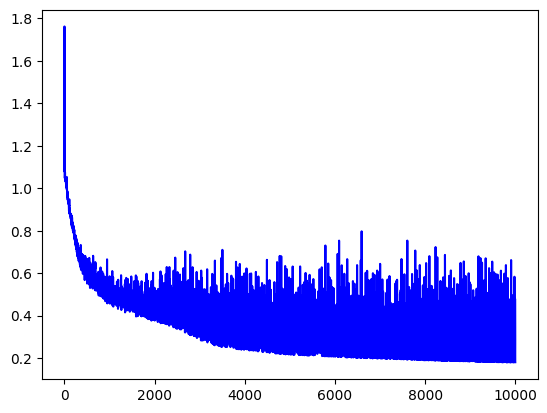

In [ ]:
# Driver Code for SGD(Red Curve)
# Create dataset
from matplotlib import pyplot as plt
loss_list_rms=[]
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_RMSprop(learning_rate=0.05)
#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    loss_list_rms.append(loss)
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
x1=range(epoch+1)
plt.plot(x1,loss_list_rms,color='blue')
#plt.plot(x1,loss_list1)

epoch: 0, acc: 0.297, loss: 1.099, lr: 0.05
epoch: 100, acc: 0.590, loss: 0.852, lr: 0.05
epoch: 200, acc: 0.687, loss: 0.694, lr: 0.05
epoch: 300, acc: 0.770, loss: 0.587, lr: 0.05
epoch: 400, acc: 0.797, loss: 0.537, lr: 0.05
epoch: 500, acc: 0.807, loss: 0.487, lr: 0.05
epoch: 600, acc: 0.790, loss: 0.509, lr: 0.05
epoch: 700, acc: 0.837, loss: 0.437, lr: 0.05
epoch: 800, acc: 0.853, loss: 0.418, lr: 0.05
epoch: 900, acc: 0.837, loss: 0.409, lr: 0.05
epoch: 1000, acc: 0.850, loss: 0.386, lr: 0.05
epoch: 1100, acc: 0.843, loss: 0.379, lr: 0.05
epoch: 1200, acc: 0.847, loss: 0.374, lr: 0.05
epoch: 1300, acc: 0.860, loss: 0.356, lr: 0.05
epoch: 1400, acc: 0.860, loss: 0.350, lr: 0.05
epoch: 1500, acc: 0.837, loss: 0.364, lr: 0.05
epoch: 1600, acc: 0.877, loss: 0.336, lr: 0.05
epoch: 1700, acc: 0.863, loss: 0.341, lr: 0.05
epoch: 1800, acc: 0.863, loss: 0.336, lr: 0.05
epoch: 1900, acc: 0.867, loss: 0.323, lr: 0.05
epoch: 2000, acc: 0.877, loss: 0.317, lr: 0.05
epoch: 2100, acc: 0.850, 

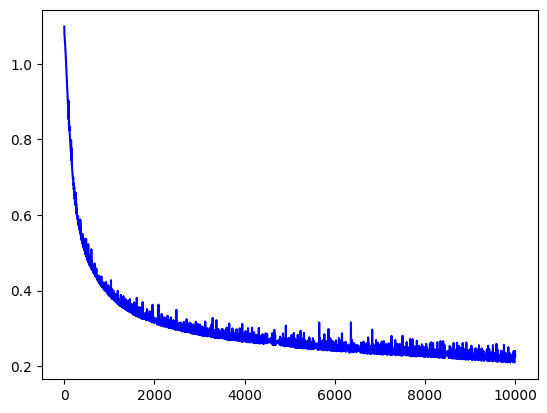

In [ ]:
# Driver Code for SGD(Red Curve)
# Create dataset
from matplotlib import pyplot as plt
loss_list_adm=[]
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adam(learning_rate=0.05)
#optimizer = Optimizer_Adam(learning_rate=0.05, decay=5e-7)
# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    loss_list_adm.append(loss)
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
x1=range(epoch+1)
plt.plot(x1,loss_list_adm,color='blue')#plt.plot(x1,loss_list1)

[]

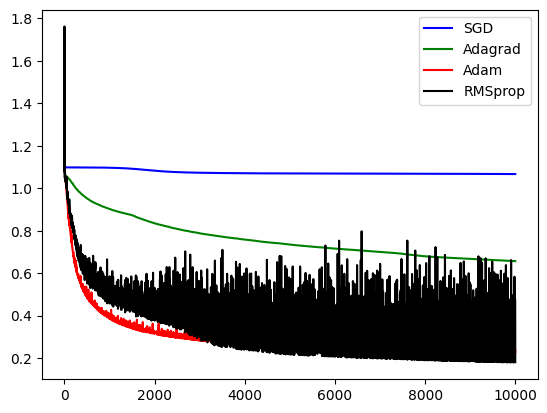

In [ ]:
x1=range(epoch+1)
plt.plot(x1,loss_list1,color='blue')#1
plt.plot(x1,loss_list_ad2,color='green')#1
plt.plot(x1,loss_list_adm,color='red')#1
plt.plot(x1,loss_list_rms,color='black')#1
plt.legend(["SGD","Adagrad","Adam","RMSprop"])
plt.plot()